In [25]:
import os
import cv2
import pickle
import zipfile
import numpy as np
from google.colab import files
from google.colab import drive
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [26]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print("Please upload the OpenCV face detector weights file (.pb and .pbtxt files)")
uploaded = files.upload()

Please upload the OpenCV face detector weights file (.pb and .pbtxt files)


Saving opencv_face_detector_uint8.pb to opencv_face_detector_uint8.pb


In [4]:
print("Please upload the OpenCV face detector  model architecture file (.pb and .pbtxt files)")
uploaded1 = files.upload()

Please upload the OpenCV face detector  model architecture file (.pb and .pbtxt files)


Saving opencv_face_detector.pbtxt to opencv_face_detector.pbtxt


In [5]:
# Get the file paths
pb_files = [filename for filename in uploaded.keys() if filename.endswith('.pb')]
pbtxt_files = [filename for filename in uploaded1.keys() if filename.endswith('.pbtxt')]

In [27]:
 # Load the OpenCV face detector model
net = cv2.dnn.readNetFromTensorflow(pb_files[0], pbtxt_files[0])# Load the face recognition model
fr_model_path = '/content/drive/My Drive/saouda_FR_model_75.h5'
model = load_model(fr_model_path)

In [7]:
import pickle

# Load class_labels from the saved file on Google Drive
with open('/content/drive/MyDrive/class_labels.pkl', 'rb') as f:
    class_labels = pickle.load(f)

threshold = 0.7
# Define the number of classes, class embeddings, class labels, and threshold
num_classes = 105 # Number of classes for face recognition

# Load class embeddings
with open('/content/drive/MyDrive/class_embeddings.pkl', 'rb') as f:
    class_embeddings = pickle.load(f)

In [16]:
def process_frame(frame):
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            face_img = frame[startY:endY, startX:endX]
            face_img = cv2.resize(face_img, (120, 120))
            face_img = img_to_array(face_img)
            face_img = np.expand_dims(face_img, axis=0)
            face_img = face_img / 255.0

            # Perform face recognition
            predictions = model.predict(face_img)

            # Calculate cosine similarity with each class
            similarities = []
            for class_name, embeddings in class_embeddings.items():
                class_embedding = np.mean(embeddings, axis=0)  # Assuming embeddings is a list of embeddings for each image
                similarity = cosine_similarity(predictions, class_embedding)
                similarities.append(similarity)

            max_similarity = max(similarities)
            if max_similarity >= threshold:
                predicted_class_idx = np.argmax(similarities)
                predicted_class_label = class_labels[predicted_class_idx]
            else:
                predicted_class_label = "Unknown Person"

            # Display the recognized face and the person's name or "No Class"
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 2)
            cv2.putText(frame, predicted_class_label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return frame

# **Capture Photo And Test it**

In [17]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Function to capture a photo from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
      ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 82ms/step


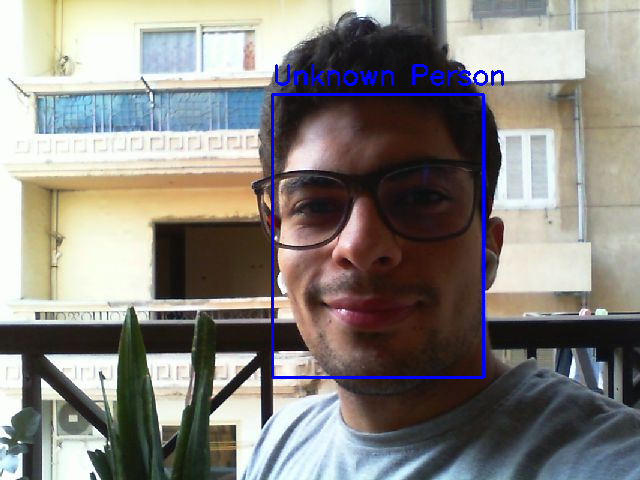

In [18]:
try:
      # Capture a photo
    filename = take_photo()

        # Read the captured image
    frame = cv2.imread(filename)

        # Process the frame for face recognition
    processed_frame = process_frame(frame)

        # Display the processed frame
    cv2_imshow(processed_frame)

except Exception as e:
        # If an error occurs, print the error and continue
    print(str(e))

# **Test on Live Stream WEBCAM**

In [24]:
# Capture video from webcam
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame for face recognition
    processed_frame = process_frame(frame)

    # Display the processed frame
    cv2_imshow(processed_frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()